 #### Finetuning the convnet: 
    Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.

#### ConvNet as fixed feature extractor: 
    Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.


## Deely Understand about Traing, Validation , Test Phase

### Training Phase :
- Similar to the a lecture being taught in college. Concepts discussed in class and reasoning discussed by the professor to give you an idea about the problem domain. This usually comprises about 65% of the time you spend in college.

### Validation Phase :
- This is the tutorials you attend with the Teaching Assistant. You have learnt some concepts with the professor is training you during lecture hours. Here the TA usually gives you an assignment you are expected to solve and then discusses the solutions so that you can formalise your understanding of the concepts before you go to the final exam ( Testing Phase). This like tutorials would comprise about 20% of the total time.

### Testing Phase :
- This is the final exam. This objective here is to assess the concepts you learnt initially in the lectures(Training) and built upon in the tutorials(Validation). Here, ideally you are not provided with the answers beforehand :p. You submit your answers and an analysis of your performance is provided by various metrics. The testing phases tests the generalisation capabilities of the model(student in this case) beyond the training set.( Questions covered in lectures and tutorials).

In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os 
from torch.autograd import Variable
import copy
from PIL import Image

#interactive mode
plt.ion() 

# Load Data

#### Train a model to classify ants and bees.

    - Training Images: 120 Imgs/class
    - Validation Images: 75 Imgs/class

In [2]:
# Data augmentation and normalization for training
# Just normalization for validtion

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(299),
        # transforms.RandomSizedCrop(224),
        transforms.CenterCrop(299),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize (299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data\hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualize a few images

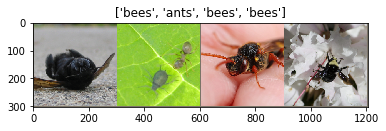

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training the model
- Scheduling the learning rate
- Saving the best model

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs= 25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                #Set model to training mode
                model.train() 
            else:
                #Set model to evaluate mode
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            #Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #Zero the params gradients
                optimizer.zero_grad()
                
                ### Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    if phase == 'val':
                        _, preds = torch.max(outputs, 1)
                    elif phase == 'train':
                        _, preds = torch.max(outputs[1], 1)
                        
                    # for nets that have multiple outputs such as inception
                    if isinstance(outputs, tuple):
                        loss = sum((criterion(o,labels) for o in outputs))
                    else:
                        loss = criterion(outputs, labels)
                
                    
                    #backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # Statistics
                if phase == 'val':
                        running_loss += loss.item() * inputs.size(0)     
                elif phase == 'train':
                        _, preds = torch.max(outputs[1], 1)
                running_loss += loss.item() * inputs.size(0)        
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss,epoch_acc))
        
            # Deep copy the model
            if phase == 'val':
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    
    #Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Visualizing the model predictions
This is generic function to display predictions for a few images

In [5]:
def visualize_model(model, num_images= 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                # plt.subplot(行数, 列数, 何番目のプロットか)
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode= was_training)
                    return
        model.train(model=was_training)

# Finetuning the convnet
- Load a pretrained model and reset final fully connected layer

### Decaying Learning Rate :
- Most of the times we start with a higher learning rate so that we can reduce the loss faster and then after a few epochs you would like to reduce it so that the learning becoming slower. I found this function from pytorch tutorials very useful.

- Ex:
    ##### Create a learning rate adjustment function that divides the learning rate by 10 every 30 epochs
def adjust_learning_rate(epoch):
    
        lr = 0.001

        if epoch > 180:
            lr = lr / 1000000
        elif epoch > 150:
            lr = lr / 100000
        elif epoch > 120:
            lr = lr / 10000
        elif epoch > 90:
            lr = lr / 1000
        elif epoch > 60:
            lr = lr / 100
        elif epoch > 30:
            lr = lr / 10

        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

Here pretrained model is using Resnet18

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all params are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr= 0.001, momentum= 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train And Evaluate

In [ ]:
model_ft = train_model(model_ft, criterion, 
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=25)

In [ ]:
#Visualize model 
visualize_model(model_ft)


# ConvNet as fixed feature extractor

Freeze all the network except the final layer. Set 'requires_grad == False' to freeze the parameters so that the gradients are not computed in backward().

In [6]:
model_conv = models.inception_v3(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
# parameters of newly constructed modules have requires_grad = True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr= 0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# ERROR
- if self.training and self.aux_logits:
            return x, aux
            
            loss = None
            # for nets that have multiple outputs such as inception
            if isinstance(outputs, tuple):
                loss = sum((criterion(o,labels) for o in outputs))
            else:
                loss = criterion(outputs, labels)

In [7]:
model_conv = train_model(model_conv, criterion, 
                         optimizer_conv,
                         exp_lr_scheduler,
                         num_epochs=25)

Epoch 0/24
----------
train Loss: 8.5269 Acc: 0.0000
val Loss: 0.4097 Acc: 0.8954

Epoch 1/24
----------
train Loss: 8.3441 Acc: 0.0000
val Loss: 0.3482 Acc: 0.8954

Epoch 2/24
----------
train Loss: 8.3082 Acc: 0.0000
val Loss: 0.3038 Acc: 0.8954

Epoch 3/24
----------
train Loss: 8.3101 Acc: 0.0000
val Loss: 0.2596 Acc: 0.9150

Epoch 4/24
----------
train Loss: 8.3797 Acc: 0.0000
val Loss: 0.4388 Acc: 0.7582

Epoch 5/24
----------
train Loss: 8.2891 Acc: 0.0000
val Loss: 0.2475 Acc: 0.9085

Epoch 6/24
----------
train Loss: 8.2627 Acc: 0.0000
val Loss: 0.3460 Acc: 0.8627

Epoch 7/24
----------
train Loss: 8.2251 Acc: 0.0041
val Loss: 0.2515 Acc: 0.8889

Epoch 8/24
----------
train Loss: 8.2347 Acc: 0.0000
val Loss: 0.2596 Acc: 0.8758

Epoch 9/24
----------
train Loss: 8.2284 Acc: 0.0000
val Loss: 0.2331 Acc: 0.9020

Epoch 10/24
----------
train Loss: 8.2089 Acc: 0.0000
val Loss: 0.2633 Acc: 0.8889

Epoch 11/24
----------
train Loss: 8.1718 Acc: 0.0041
val Loss: 0.2647 Acc: 0.9020

Ep

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

# Prediction

- First we pass an array of transformations using 'transform.Compose. RandomHorizontalFlip' randomly flips the images horizontally. RandomCrop randomly crops the images. Below is an example of horizontal flipping.


-  ToTensor converts the images into a format usable by PyTorch. Normalize with the values given below would make all our pixels range between -1 to +1

Image Input -> Crop -> Convert to Tensor -> Normalize -> 

In [ ]:
def predict_image(model, image_path):
    print("Prediction in progress")
    image = Image.open(image_path)

    # Define transformations for the image, should (note that imagenet models are trained with image size 224)
    transformation = transforms.Compose([
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all images as batches
    image_tensor = image_tensor.unsqueeze_(0)

    if torch.cuda.is_available():
        input = Variable(image_tensor.cuda())

    # Turn the input into a Variable
    #input = Variable(image_tensor)
    #input = input.to(device)

    
    # Predict the class of the image
    output = model(input)
    
    _, preds = torch.max(output, 1)
            
    ax = plt.subplot(121)
    ax.axis('off')
    ax.set_title('predicted: {}'.format(class_names[preds]))
    imshow(input.cpu().data[0])



image_path = 'data\\hymenoptera_data\\test\\download3.jfif'
predict_image(model_conv, image_path)

In [ ]:
def save_models(epoch):
    torch.save(model.state_dict(), "data/antbeeResNetModel_{}.model".format(epoch))
    print("Chekcpoint saved")
    
    '''
    #Save Model
    PATH1 = 'data/antbeeResNetModel.pt'
    PATH2 = 'data/antbeeResNetModel.pth.tar'

    #torch.save(model_conv, PATH2)
    model = torch.load(PATH2)
    '''

save_models(24)

In [ ]:
model_conv